## Analyzing sharpwave temporal features

Time series data can be characterized using oscillatory components, but assumptions of sinusoidality are for real data rarely fulfilled. See *"Brain Oscillations and the Importance of Waveform Shape"* Cole et al 2017 (https://doi.org/10.1016/j.tics.2016.12.008) for a great motivation.
We implemented here temporal characterstics based on individual trough and peak relations, based on the scipy *find_peaks* function (https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html). The function parameter *distance* can be specified in the *nm_settings.json*. Temporal features can be calculated twice for troughs and peaks. In the settings, this can be specified by setting *estimate* to true in *detect_troughs* and/or *detect_peaks*. A statistical measure (e.g. mean, max, median, var) can be defined as a resulting feature from the peak and trough estimates using the *apply_estimator_between_peaks_and_troughs* setting.

In py_neuromodulation the following characteristics are implemted:

*Note that that the nomenclature is written for sharpwave troughs, but detection of peak characteristics can be computed in the same way*:


* prominence: $V_{prominence} = |\frac{V_{peak-left} + V_{peak-right}}{2}| - V_{trough}$
* sharpness: $V_{sharpnesss} = \frac{(V_{trough} - V_{trough-5 ms}) + (V_{trough} - V_{trough+5 ms})}{2}$
* rise and decay rise time
* rise and decay steepness
* width (between left and right peaks)
* interval (between troughs)

Additionally, different filter ranges can be parametrized using the *filter_ranges_Hz* setting. Filtering is necessary to remove high frequent signal fluctuations, but limits also the true estimation of sharpness and prominence due to signal smoothing.


In [ ]:
import seaborn as sb
import pandas as pd
from matplotlib import pyplot as plt
from scipy import signal
import numpy as np
from sklearn import linear_model, model_selection, metrics

import py_neuromodulation as nm
from py_neuromodulation import (
    nm_analysis,
    nm_decode,
    nm_define_nmchannels,
    nm_IO,
    nm_plots,
    nm_settings,
    nm_stats
)

We will first read the examples/data ECoG data and plot the identified features on the filtered time series. 

In [4]:
RUN_NAME, PATH_RUN, PATH_BIDS, PATH_OUT, datatype = nm_IO.get_paths_example_data()

(
    raw,
    data,
    sfreq,
    line_noise,
    coord_list,
    coord_names,
) = nm_IO.read_BIDS_data(
    PATH_RUN=PATH_RUN, BIDS_PATH=PATH_BIDS, datatype=datatype
)

settings = nm_settings.get_default_settings()
settings = nm_settings.set_settings_fast_compute(settings)

settings["features"]["fft"] = True
settings["features"]["bursts"] = False
settings["features"]["sharpwave_analysis"] = True
settings["features"]["coherence"] = False

settings["sharpwave_analysis_settings"]["estimator"]["mean"] = []
for sw_feature in list(
    settings["sharpwave_analysis_settings"]["sharpwave_features"].keys()
):
    settings["sharpwave_analysis_settings"]["sharpwave_features"][sw_feature] = True
    settings["sharpwave_analysis_settings"]["estimator"]["mean"].append(sw_feature)

nm_channels = nm_define_nmchannels.set_channels(
    ch_names=raw.ch_names,
    ch_types=raw.get_channel_types(),
    reference="default",
    bads=raw.info["bads"],
    new_names="default",
    used_types=("ecog", "dbs", "seeg"),
    target_keywords=["MOV_RIGHT_CLEAN","MOV_LEFT_CLEAN"]
)

stream = nm.Stream(
    sfreq=sfreq,
    nm_channels=nm_channels,
    settings=settings,
    line_noise=line_noise,
    coord_list=coord_list,
    coord_names=coord_names,
    verbose=False,
)
sw_analyzer = stream.run_analysis.features.features[1]


Extracting parameters from C:\code\py_neuromodulation\examples\data\sub-000\ses-right\ieeg\sub-000_ses-right_task-force_run-3_ieeg.vhdr...
Setting channel info structure...
Reading channel info from C:\code\py_neuromodulation\examples\data\sub-000\ses-right\ieeg\sub-000_ses-right_task-force_run-3_channels.tsv.
Reading electrode coords from C:\code\py_neuromodulation\examples\data\sub-000\ses-right\ieeg\sub-000_ses-right_space-mni_electrodes.tsv.
No data specified. Sanity checks related to the length of the signal relative to the filter order will be skipped.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 7.50 Hz
- Upper transition bandwidth: 7.50 Hz
- Filter length: 999 samples (0.999 sec)



The plotted example time series, visualized on a short time scale, shows the relation of identified peaks, troughs, and estimated features:

Text(0, 0.5, 'a.u.')

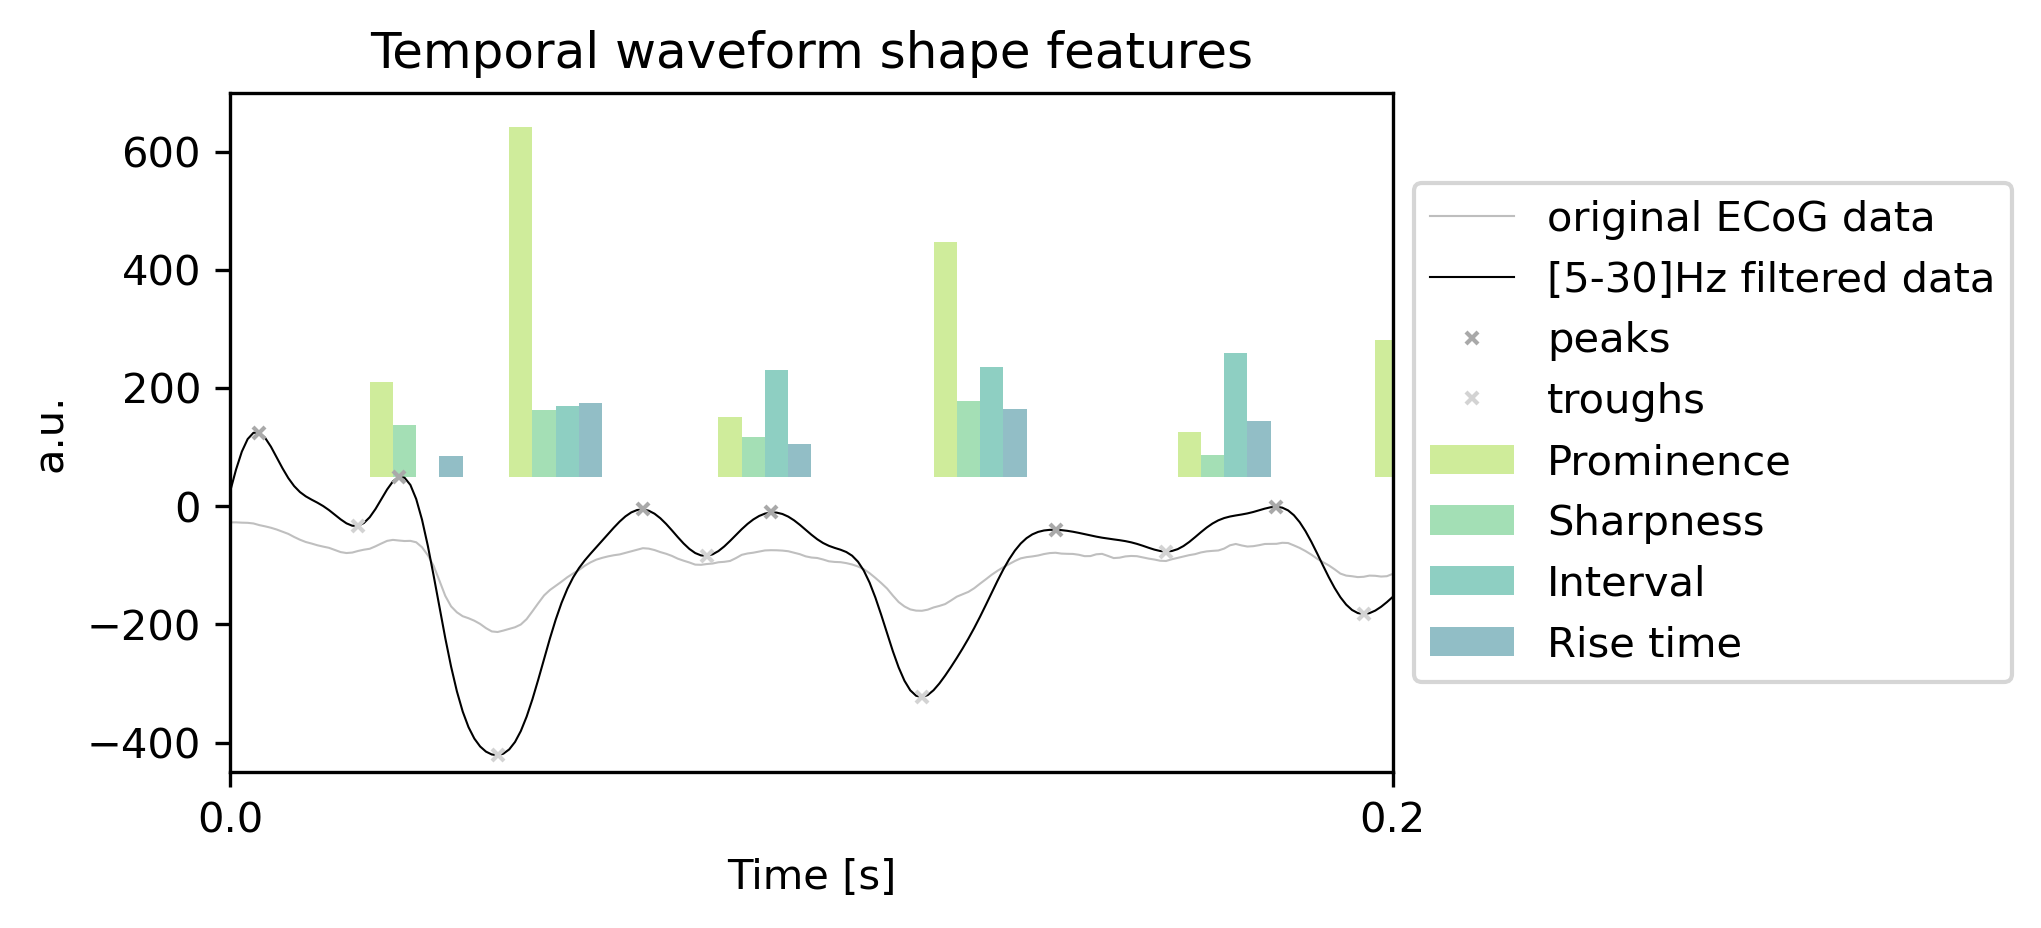

In [67]:
data_plt = data[5, 28000:30000]


sw_analyzer._initialize_sw_features()
filtered_dat = np.convolve(
    data_plt,
    sw_analyzer.list_filter[0][1],
    mode="same"
)
#filtered_dat = filtered_dat[500:-500]

troughs = signal.find_peaks(-filtered_dat, distance=10)[0]
peaks = signal.find_peaks(filtered_dat, distance=5)[0]

sw_analyzer.data_process_sw = filtered_dat
sw_analyzer.analyze_waveform()

WIDTH = BAR_WIDTH = 4
BAR_OFFSET = 50
OFFSET_TIME_SERIES = -100
SCALE_TIMESERIES = 3

hue_colors = sb.color_palette("viridis_r", 6)

plt.figure(figsize=(5, 3), dpi=300)
plt.plot(OFFSET_TIME_SERIES + data_plt, color="gray", linewidth=0.5, alpha=0.5, label="original ECoG data")
plt.plot(OFFSET_TIME_SERIES + filtered_dat*SCALE_TIMESERIES, linewidth=0.5, color="black", label="[5-30]Hz filtered data")

plt.plot(peaks, OFFSET_TIME_SERIES + filtered_dat[peaks]*SCALE_TIMESERIES, "x", label="peaks",markersize=3, color="darkgray")
plt.plot(troughs, OFFSET_TIME_SERIES + filtered_dat[troughs]*SCALE_TIMESERIES, "x", label="troughs", markersize=3, color="lightgray")

plt.bar(troughs[:-1]+BAR_WIDTH, np.array(sw_analyzer.prominence)*4, bottom=BAR_OFFSET, width=WIDTH, color=hue_colors[0], label="Prominence", alpha=0.5)
plt.bar(troughs[:-1]+BAR_WIDTH*2, -np.array(sw_analyzer.sharpness)*6, bottom=BAR_OFFSET, width=WIDTH, color=hue_colors[1], label="Sharpness", alpha=0.5)
plt.bar(troughs[:-1]+BAR_WIDTH*3, np.array(sw_analyzer.interval)*5, bottom=BAR_OFFSET, width=WIDTH, color=hue_colors[2], label="Interval", alpha=0.5)
plt.bar(troughs[:-1]+BAR_WIDTH*4, np.array(sw_analyzer.rise_time)*5, bottom=BAR_OFFSET, width=WIDTH, color=hue_colors[3], label="Rise time", alpha=0.5)

plt.xticks(np.arange(0, 2000, 200), np.round(np.arange(0, 2, 0.2), 2))
plt.xlabel("Time [s]")
plt.title("Temporal waveform shape features")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(-450, 700)
plt.xlim(0, 200)
plt.ylabel("a.u.")

See in the following example a time series example, that is aligned to movement. With movement onset the promince, sharpness, and interval features are reduced:

Text(0, 0.5, 'a.u.')

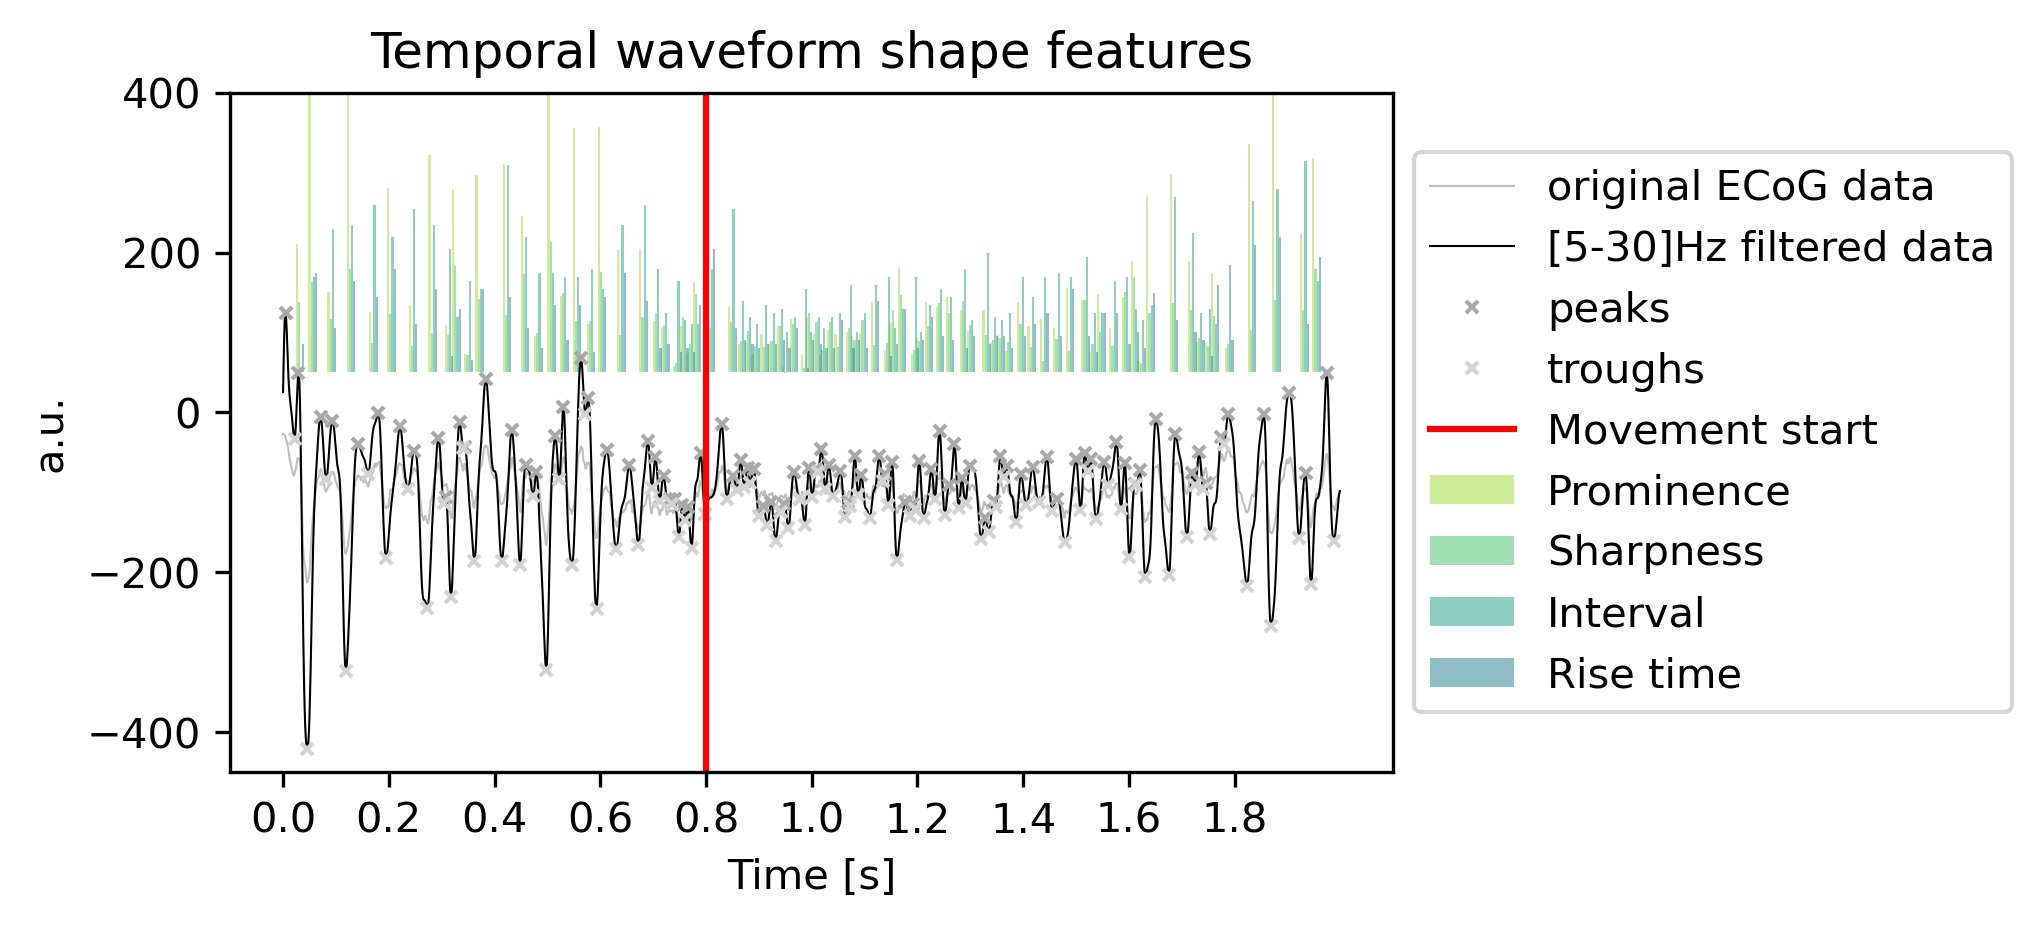

In [72]:
plt.figure(figsize=(5, 3), dpi=300)
plt.plot(OFFSET_TIME_SERIES + data_plt, color="gray", linewidth=0.5, alpha=0.5, label="original ECoG data")
plt.plot(OFFSET_TIME_SERIES + filtered_dat*SCALE_TIMESERIES, linewidth=0.5, color="black", label="[5-30]Hz filtered data")

plt.plot(peaks, OFFSET_TIME_SERIES + filtered_dat[peaks]*SCALE_TIMESERIES, "x", label="peaks",markersize=3, color="darkgray")
plt.plot(troughs, OFFSET_TIME_SERIES + filtered_dat[troughs]*SCALE_TIMESERIES, "x", label="troughs", markersize=3, color="lightgray")

plt.bar(troughs[:-1]+BAR_WIDTH, np.array(sw_analyzer.prominence)*4, bottom=BAR_OFFSET, width=WIDTH, color=hue_colors[0], label="Prominence", alpha=0.5)
plt.bar(troughs[:-1]+BAR_WIDTH*2, -np.array(sw_analyzer.sharpness)*6, bottom=BAR_OFFSET, width=WIDTH, color=hue_colors[1], label="Sharpness", alpha=0.5)
plt.bar(troughs[:-1]+BAR_WIDTH*3, np.array(sw_analyzer.interval)*5, bottom=BAR_OFFSET, width=WIDTH, color=hue_colors[2], label="Interval", alpha=0.5)
plt.bar(troughs[:-1]+BAR_WIDTH*4, np.array(sw_analyzer.rise_time)*5, bottom=BAR_OFFSET, width=WIDTH, color=hue_colors[3], label="Rise time", alpha=0.5)

plt.axvline(x=800, label="Movement start", color="red")

plt.xticks(np.arange(0, 2000, 200), np.round(np.arange(0, 2, 0.2), 2))
plt.xlabel("Time [s]")
plt.title("Temporal waveform shape features")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(-450, 400)
plt.ylabel("a.u.")

In the *sharpwave_analysis_settings* the *estimator* keyword further specifies which statistics is computed based on the individual features in one batch. The "global" setting *segment_length_features_ms* specifies the time duration for feature computation. Since there can be a different number of identified waveform shape features for different batches (i.e. different number of peaks/troughs), taking a stastical measure (e.g. the maximum or mean) will be necessary for feature comparison. 

### Example time series computation for movement decoding

We will now read the ECoG example/data and investigate if samples differ across movement states. Therefore we compute features and enable the default *sharpwave* features.  

In [23]:
RUN_NAME, PATH_RUN, PATH_BIDS, PATH_OUT, datatype = nm_IO.get_paths_example_data()

(
    raw,
    data,
    sfreq,
    line_noise,
    coord_list,
    coord_names,
) = nm_IO.read_BIDS_data(
    PATH_RUN=PATH_RUN, BIDS_PATH=PATH_BIDS, datatype=datatype
)

nm_channels = nm_define_nmchannels.set_channels(
    ch_names=raw.ch_names,
    ch_types=raw.get_channel_types(),
    reference="default",
    bads=raw.info["bads"],
    new_names="default",
    used_types=("ecog", "dbs", "seeg"),
    target_keywords=["MOV_RIGHT_CLEAN","MOV_LEFT_CLEAN"]
)

settings = nm_settings.get_default_settings()
settings = nm_settings.reset_settings(settings)

settings["features"]["sharpwave_analysis"] = True

stream = nm.Stream(
    sfreq=sfreq,
    nm_channels=nm_channels,
    settings=settings,
    line_noise=line_noise,
    coord_list=coord_list,
    coord_names=coord_names,
    verbose=False,
)


Extracting parameters from C:\code\py_neuromodulation\examples\data\sub-000\ses-right\ieeg\sub-000_ses-right_task-force_run-3_ieeg.vhdr...
Setting channel info structure...
Reading channel info from C:\code\py_neuromodulation\examples\data\sub-000\ses-right\ieeg\sub-000_ses-right_task-force_run-3_channels.tsv.
Reading electrode coords from C:\code\py_neuromodulation\examples\data\sub-000\ses-right\ieeg\sub-000_ses-right_space-mni_electrodes.tsv.


In [26]:
df_features = stream.run(
    data=data,
    out_path_root=None,
    folder_name=None,
)

We can then plot two examplary features, prominence and interval, and see that the movement amplitude can be clustered with those two features alone:

Text(0.5, 1.0, 'Temporal features predict movement amplitude')

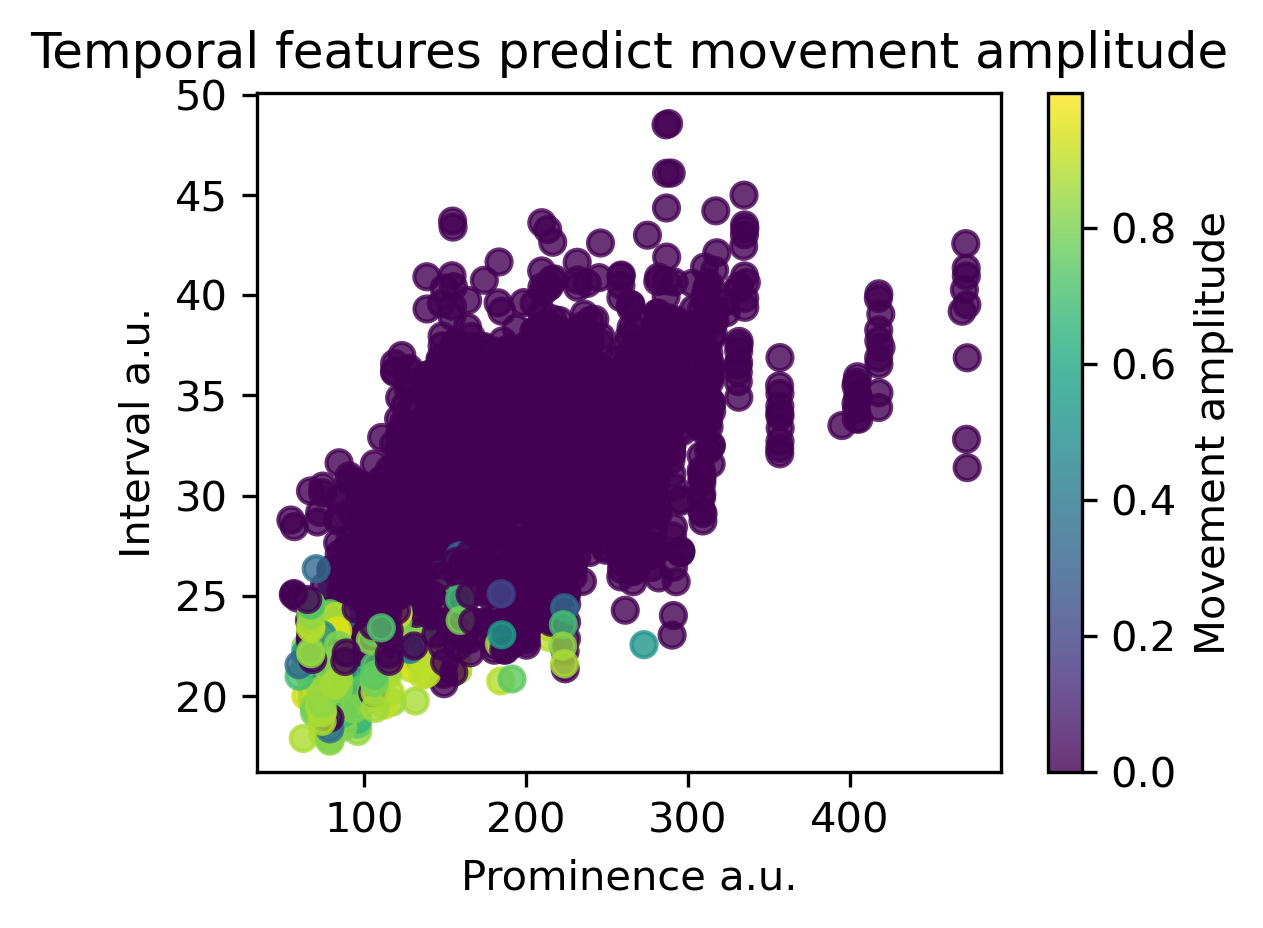

In [73]:
plt.figure(figsize=(4, 3), dpi=300)
plt.scatter(
    df_features["ECOG_RIGHT_0-avgref_Sharpwave_Max_prominence_range_5_80"],
    df_features["ECOG_RIGHT_5-avgref_Sharpwave_Mean_interval_range_5_80"],
    c=df_features["MOV_LEFT_CLEAN"], alpha=0.8
)
cbar = plt.colorbar()
cbar.set_label("Movement amplitude")
plt.xlabel("Prominence a.u.")
plt.ylabel("Interval a.u.")
plt.title("Temporal features predict movement amplitude")